# Assignment 1.2: 

# Theory 
## Questions 
- Why apply a logarithm on the likelihood?  
    - Applying the Log on the likelihoods helps us
- What are analytical reasons?  
    - First of all, applying the log helps us making the derrivation easy to handle. Also, the maximizing the log function is equivalent to maximizing the likelihood function.
- What are numerical reasons?  
    - Using the Log helps us to avoid getting values infinity close to zero and numerical stability is guaranteed. 
- Does it affect the estimator?  
    - No, applying the Log in this case will not effect the end result of the estimator.  

## Task 1
We observe an experiment $D=\{x_1,\cdots, x_n\}$ with i.i.d. $x_i \sim p(x_i|\mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$.
What is the MLE for $\mu$ and $\sigma^2$ ?

the optimal parameters are:

![image](images/a_1_2_t1.png)

## Task 2
We observe am experiment $D=\{(x_1,y_1),\cdots, (x_n,y_n)\}$. We assume a linear model with Gaussian noise: $y_i = x_i\cdot a + b + \epsilon_i$  with i.i.d. $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$.
       What is the MLE for $a,b$ and $\sigma^2$ ?

![image](images/a_1_2_t2.png)


## Task 3
Assume we have a Bernoulli process, where we toss a coin multiple times.  
Let $D = (x_1, x_2, . . . , x_7) = (0, 0, 1, 1, 0, 0, 1)$ be the measurements. 
Assume $p(x_i|\theta)=
\begin{cases}
\theta  & \text{if} ~ x_i=1 ~ (head),\\
1-\theta ~ &\text{if} ~ x_i=0 ~ (tail)
\end{cases}$

- Let $p(\theta)=\mathcal{N}(0.5,0.1)$. What is the MAP estimator $\theta_{MAP}$? What is the probability of tossing tails two times $P(x_8=0, x_9=0|\theta_{MAP})$
- Let $p(\theta)=\mathcal{U}(0,1)$. What is the probability of the next toss to be head $P(x_8=1|D)$ 


# Praxis

The goal of the exercise is to implement a Maximum Likelihood Estimator for a normal distribution.  
We create $n$ data samples from a 2D normal distribution $X_i \sim \mathcal{N}(\mu, \Sigma)$

We would like to estimate the mean $mu$ using a numerical appraoch with gradient ascent.

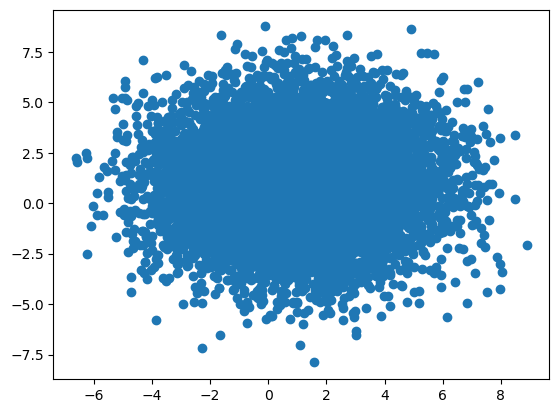

In [12]:
import numpy as np 
import torch
import matplotlib.pyplot as plt

n = 10000 # number of samples (descrease the number if computations take too much time)
mu, sigma = np.ones(2), 5*np.eye(2) # mean and standard deviation of ground truth distribution
data = np.random.multivariate_normal(mu, sigma, n) # sample n data points from the distribution
plt.scatter(data[:,0],data[:,1])
plt.show()


# Maximum Likelihood

The likelihood of a single data point is given as:  
$$p(x; \mu, \Sigma) = \dfrac{1}{\sqrt{|\Sigma|(2\pi)^2}} 
  \exp\left( -\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T \right)$$

The log-likelihood is:
$$\log (p(x; \mu, \Sigma)) =-\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T  + C $$

The joint likelihood over the whole data is:  
$$p(D;\mu, \Sigma) = \prod_i^n p(x_i; \mu, \Sigma)$$

We would like to find $\mu$ that has the highest likelihood for the given data. We assume for now, that $\Sigma$ is known:
$$ \max_\mu  p(D;\mu, \Sigma) $$
This is equivalent to maximizing the log-likelihood:
$$\Leftrightarrow  \max_\mu L(\mu) := \log (p(D;\mu, \Sigma))$$ 

Since $L(\mu)$ is a differentiable function, we can try to find the maximum using gradient ascent to find the local maximum.  
We can utilize Pytorch automatic differentiation to compute the gradients for us.  

Given are two heper functions:
1. the log-likelihood $L(\mu)$ for a given dataset
2. a visualization of the log-likelihood over a range $[-5,5]\times [-5,5]$ as a heatmap.

In [13]:
def L(X, mu, sigma):
    """ 
    Computes the log-likelihood over a dataset X for an estimated normal distribution parametrized 
    by mean mu and covariance sigma

    X : Tensor 
        A data matrix of size n x 2 
    mu: Tensor of size 2
        a tensor with two entries describing the mean
    sigma: Tensor of size 2x2
        covariance matrix
    """
    diff = X-mu
    z = -0.5*diff@sigma.inverse()*diff
    return z.sum()

def vizualize(X, mus, sigma):
    """ 
    Plots a heatmap of a likelihood evaluated for different mu.
    It also plots a list of gradient updates. 

    X : Tensor 
        A data matrix of size n x 2 
    mus: list[Tensor]  
        A list of 2D tensors. The tensors should be detached from and on CPU.
    sigma: Tensor of size 2x2
        covariance matrix
    """
    loss = lambda x,y: L(X,torch.tensor([x,y]),sigma)
    loss = np.vectorize(loss)
    space = np.linspace(-5,5,100)
    x,y  = np.meshgrid(space,space)
    zs = np.array(loss(np.ravel(x), np.ravel(y)))
    z = zs.reshape(x.shape)
    plt.pcolormesh(x,y, z )

    mu_x, mu_y = zip(*mus)
    plt.plot(mu_x, mu_y)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.show()


### Example Use of functions:

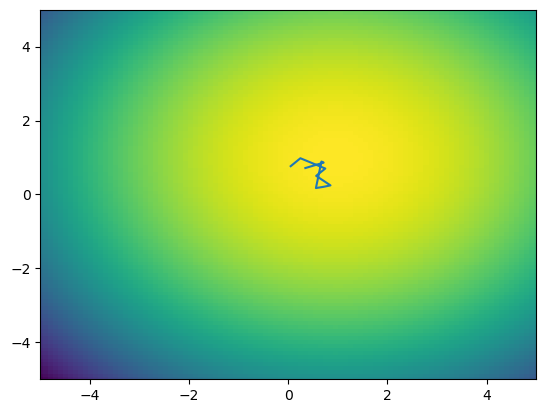

In [14]:
mu = torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

#loss = L(X,mu, sigma)  # computing loss
#loss.backward()  # backpropagation
#mu.grad  # gradients are stored in the object


mus = [torch.rand(2) for _ in range(10)] # a list 2D mu updates (dont)
vizualize(X,mus,sigma) 

## Task 1 : MLE using gradient ascent

Find the maximum by computing gradient ascent:
$$ \mu_{t+1} = \mu_{t} + \lambda \dfrac{d}{d \mu}L(\mu) $$

1. Implement a function that does the following steps:
    - initialize $\mu_0 = (0,0)^T$
    - compute Likelihood $L(\mu)$ 
    - calculate gradient $\dfrac{d}{d \mu}L(\mu) $ using Pytorch's automatic differentiation
    - update $\mu$
    - repeat until convergence or after certain amount of steps 
2. Visualize your gradient updates
3. How does the learning rate $\lambda$ affect convergence?

Likelihoods: 


C:\Users\alex\AppData\Local\Temp\ipykernel_12596\2573626569.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


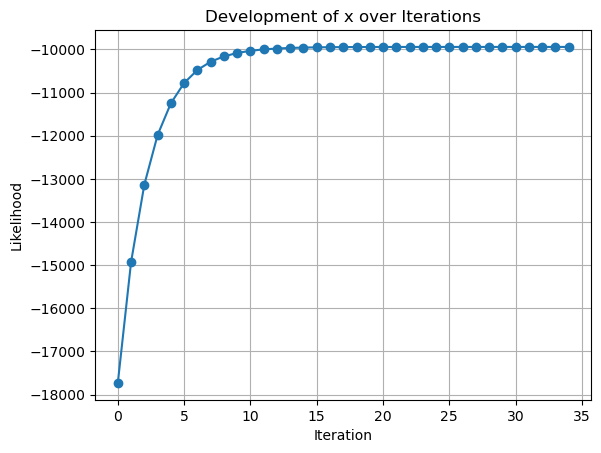

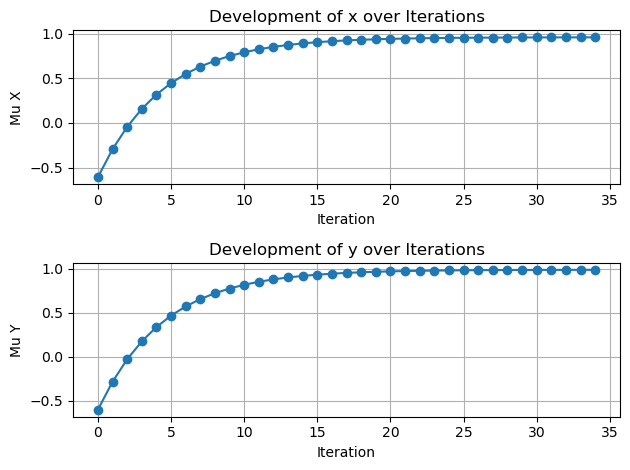

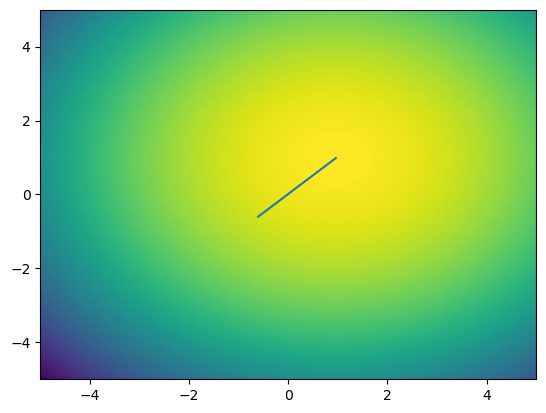

In [15]:
mu = torch.tensor([-1,-1],dtype=torch.float64, requires_grad=True) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

learning_rate = 0.0001

lhoods = []
mus = []

for i in range(35):
    #print("loop " + str(i) + " --------")
    likelihood = L(X, mu, sigma)
    likelihood.backward()
    with torch.no_grad():
        mu += learning_rate * mu.grad
        mus.append(torch.clone(mu))
        lhoods.append(likelihood.numpy())
    mu.grad.zero_()

print("Likelihoods: ")
plt.plot(lhoods, marker='o')
plt.title('Development of x over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Likelihood')
plt.grid(True)
plt.show()

mus = np.array(mus)

fig, axs = plt.subplots(2)

# Plot Mu X
axs[0].plot(mus[:, 0], marker='o')
axs[0].set_title('Development of x over Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Mu X')
axs[0].grid(True)

# Plot Mu Y
axs[1].plot(mus[:, 1], marker='o')
axs[1].set_title('Development of y over Iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Mu Y')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with subplots
plt.show()

vizualize(X,mus,sigma)

## Task 2: Better Gradient Updates

1. Change your vanilla gradient updates to a more sophisticated approach.  You can use any of Pytorch's optimization methods:  https://pytorch.org/docs/stable/optim.html
2. Visualize the new gradient updates
3. How and why do these methods differ?

C:\Users\alex\AppData\Local\Temp\ipykernel_28276\1203928371.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


Likelihoods: 


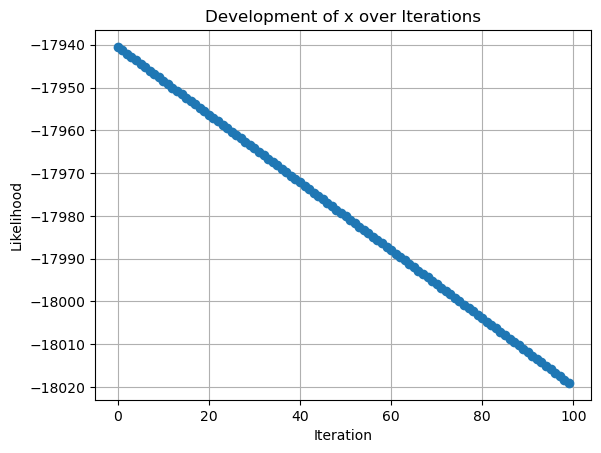

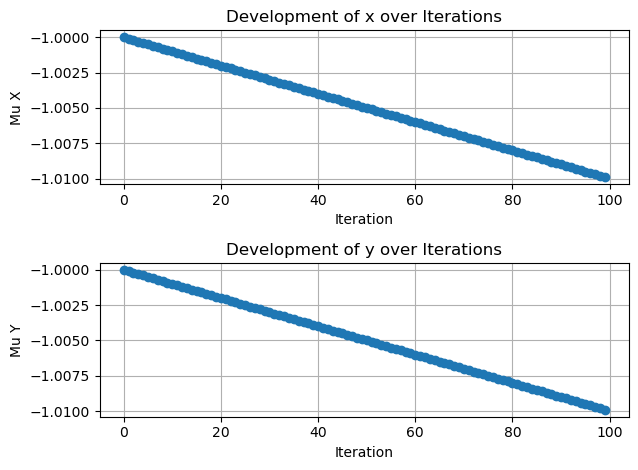

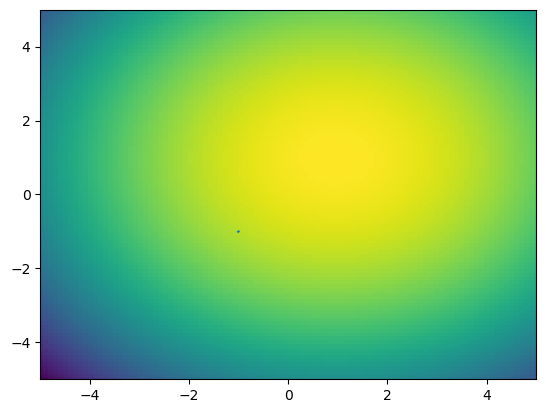

In [5]:
import torch.optim as optim

mu = torch.tensor([-1,-1],dtype=torch.float64, requires_grad=True) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

optimizer = optim.Adam([mu], lr=0.0001)

lhoods = []
mus = []

for i in range(100):
    #print("loop " + str(i) + " --------")
    def closure():
        optimizer.zero_grad()
        likelihood = L(X, mu, sigma)
        likelihood.backward()
        with torch.no_grad():
            mus.append(torch.clone(mu))
            lhoods.append(likelihood.item())

    optimizer.step(closure)

print("Likelihoods: ")
plt.plot(lhoods, marker='o')
plt.title('Development of x over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Likelihood')
plt.grid(True)
plt.show()

mus = np.array(mus)

fig, axs = plt.subplots(2)

# Plot Mu X
axs[0].plot(mus[:, 0], marker='o')
axs[0].set_title('Development of x over Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Mu X')
axs[0].grid(True)

# Plot Mu Y
axs[1].plot(mus[:, 1], marker='o')
axs[1].set_title('Development of y over Iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Mu Y')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with subplots
plt.show()

vizualize(X,mus,sigma)

## Task 3: Stochastic Gradients

Instead of optimizing over all data points
$$\max_\mu L(\mu) = \log (p(D;\mu, \Sigma))$$ 

take smaller random subsets $\hat{D} \subset D$ and optimize over approximation:
    $$\max_\mu \hat{D}(\mu) = \log (p(\hat{D};\mu, \Sigma))$$ 

1. Change your optimization method by taking random subsets of $\hat{D} \subset D$ in each iteration. 
    - How does the size $k:=|\hat{D}|$ affect convergence?
2. Visualize the log-likelihood over the whole data and for smaller subsets $k \in \{1, 5, 10, 100, 1000, ...\}$
    - What conclusions can you make?

Likelihoods w full X: 


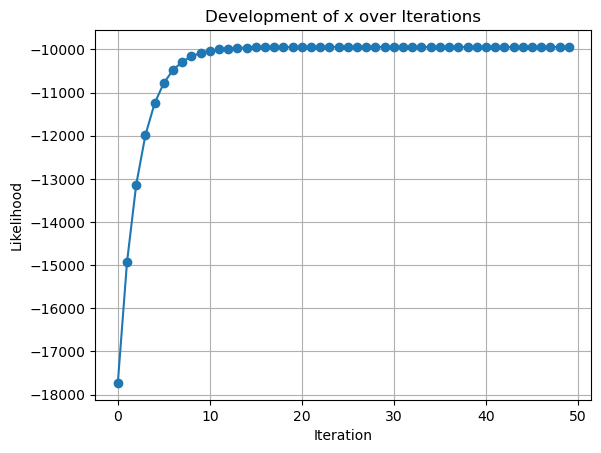

Likelihoods w batched X (n=1): 


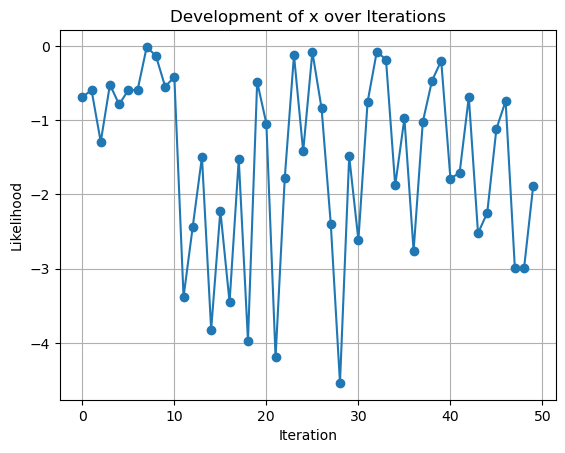

<Figure size 640x480 with 0 Axes>

Likelihoods w batched X (n=5): 


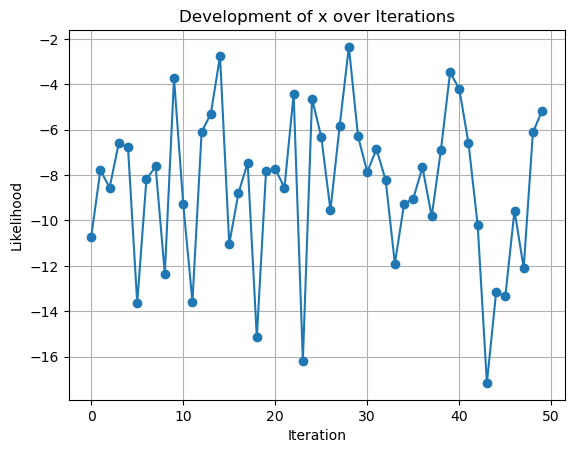

<Figure size 640x480 with 0 Axes>

Likelihoods w batched X (n=10): 


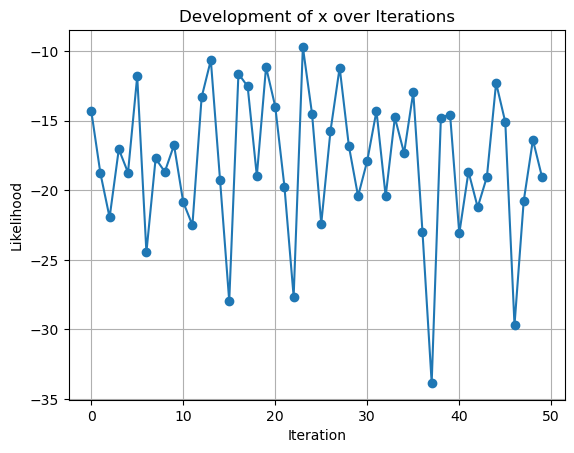

<Figure size 640x480 with 0 Axes>

Likelihoods w batched X (n=100): 


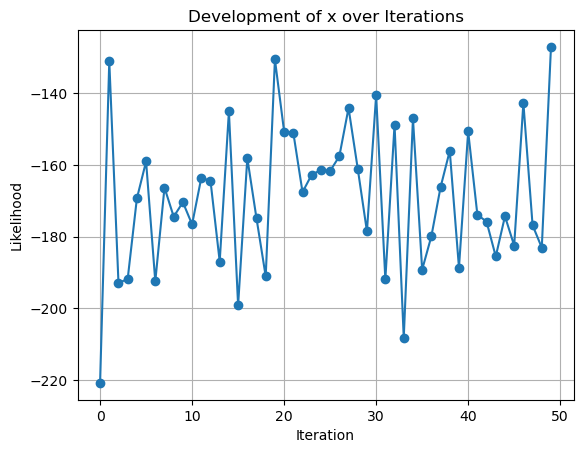

<Figure size 640x480 with 0 Axes>

Likelihoods w batched X (n=1000): 


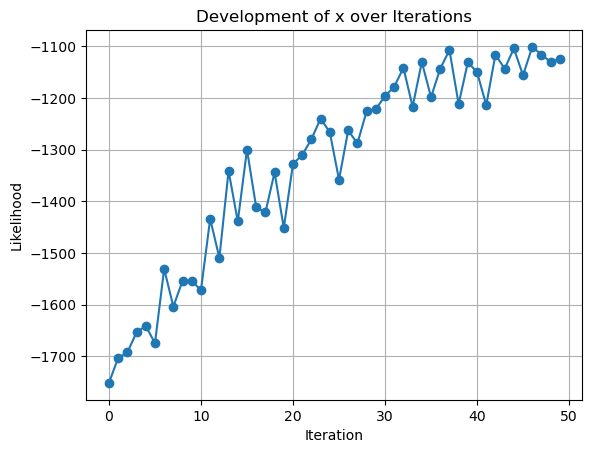

<Figure size 640x480 with 0 Axes>

Likelihoods w batched X (n=5000): 


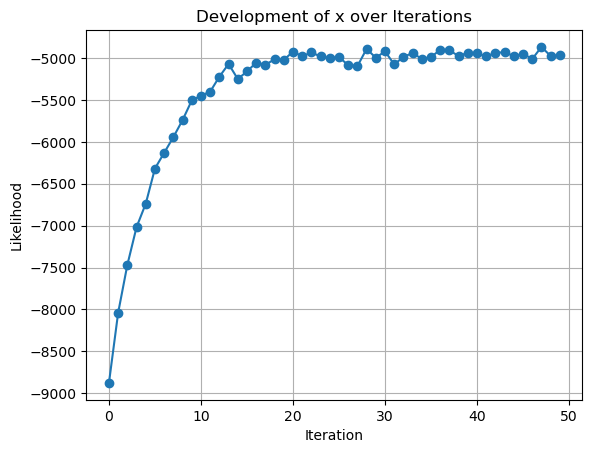

<Figure size 640x480 with 0 Axes>

In [29]:
# Based on code from Task 1

mu, sigma = np.ones(2), 5*np.eye(2)

X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

mu_f = torch.tensor([-1,-1],dtype=torch.float64, requires_grad=True) # 2D vector
sigma_f =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix

learning_rate = 0.0001

lhoods_f = []
mus_f = []

def get_random_batch(X, batch_size=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_samples = X.size(0)
    random_indices = np.random.choice(num_samples, batch_size, replace=False)
    random_batch = X[random_indices]
    return random_batch

for i in range(50):
    # Likelihood with all data
    likelihood_f = L(X, mu_f, sigma_f)
    likelihood_f.backward()
    with torch.no_grad():
        mu_f += learning_rate * mu_f.grad
        mus_f.append(torch.clone(mu_f))
        lhoods_f.append(likelihood_f.numpy())
    mu_f.grad.zero_()
    

print("Likelihoods w full X: ")
plt.plot(lhoods_f, marker='o')
plt.title('Development of x over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Likelihood')
plt.grid(True)
plt.show()

#
# For batch subsets
#

batch_sizes = [1, 5, 10, 100, 1000, 5000]
for batch_size in batch_sizes:
    mu_b = torch.tensor([-1,-1],dtype=torch.float64, requires_grad=True) # 2D vector
    sigma_b = torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
    
    lhoods_b = []
    mus_b = []

    for i in range(50):
        # Likelihood with just a small random batch of the data
        X_batch = get_random_batch(X, batch_size)
        likelihood_b = L(X_batch, mu_b, sigma_b)
        likelihood_b.backward()
        with torch.no_grad():
            mu_b += learning_rate * mu_b.grad
            lhoods_b.append(likelihood_b.numpy())
            mus_b.append(torch.clone(mu_b))
        mu_b.grad.zero_() 

    print("Likelihoods w batched X (n=" + str(batch_size) + "): ")
    plt.plot(lhoods_b, marker='o')
    plt.title('Development of x over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Likelihood')
    plt.grid(True)
    plt.show()
    
    mus_f = np.array(mus_f)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the figure with subplots
    plt.show()

#vizualize(X,mus_f,sigma_f)
#vizualize(X,mus_b,sigma_b)